In [ ]:
import pandas as pd
import numpy as np
import os
import re

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.models import Phrases
from gensim.utils import simple_preprocess
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from pprint import pprint

In [ ]:
import spacy # spacy for lemmatization

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Install the Kaggle library
! pip install kaggle

# Make a directory named “.kaggle”
! mkdir ~/.kaggle

# Copy the “kaggle.json” into this new directory
! cp kaggle.json ~/.kaggle/

# Allocate the required permission for this file
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# Download dataset
! kaggle datasets download blessondensil294/friends-tv-series-screenplay-script

! unzip friends-tv-series-screenplay-script

  0% 0.00/1.92M [00:00<?, ?B/s]
100% 1.92M/1.92M [00:00<00:00, 77.3MB/s]
Archive:  friends-tv-series-screenplay-script.zip
  inflating: S01E01 Monica Gets A Roommate.txt  
  inflating: S01E02 The Sonogram At The End.txt  
  inflating: S01E03 The Thumb.txt    
  inflating: S01E04 George Stephanopoulos.txt  
  inflating: S01E05 The East German Laundry Detergent.txt  
  inflating: S01E06 The Butt.txt     
  inflating: S01E07 The Blackout.txt  
  inflating: S01E08 Nana Dies Twice.txt  
  inflating: S01E09 Underdog Gets Away.txt  
  inflating: S01E10 The Monkey.txt   
  inflating: S01E11 Mrs. Bing.txt    
  inflating: S01E12 The Dozen Lasagnas.txt  
  inflating: S01E13 The Boobies.txt  
  inflating: S01E14 The Candy Hearts.txt  
  inflating: S01E15 The Stoned Guy.txt  
  inflating: S01E16 The Two Parts Part I.txt  
  inflating: S01E17 The Two Parts Part II.txt  
  inflating: S01E18 All The Poker.txt  
  inflating: S01E19 The Monkey Gets Away.txt  
  inflating: S01E20 The Evil Orthodontist.t

# Data Loading

In [ ]:
data = {
    'season' : [],
    'episode': [],
    'character': [],
    'line': []
}

mainData = pd.DataFrame(data)

In [ ]:
for dirname, _, filenames in os.walk('/content/rawdata'):
  df_new = pd.DataFrame()
  for filename in filenames:
    season = re.findall("([s|S][0-9]{2})E[0-9]{2}[a-zA-Z\s\-]+", filename)
    episode = re.findall("[s|S][0-9]{2}(E[0-9]{2})[a-zA-Z\s\-]+", filename)
    script = pd.read_fwf(os.path.join(dirname, filename))
    for index, text in script.iterrows():
      line = text[0]
      character = re.findall("Monica:|Rachel:|Joey:|Chandler:|Ross:|Phoebe:|MONICA:|RACHEL:|JOEY:|CHANDLER:|ROSS:|PHOEBE:|Gunther:|GUNTHER:|Janice:|JANICE:|Ursula:|URSULA:|Carol:|CAROL:|Susan:|SUSAN:|Barry:|BARRY:|Mindy:|MINDY:|David:|DAVID:|Julie:|JULIE:|Russ:|RUSS:|Richard:|RICHARD:|Estelle:|ESTELLE:|Mark:|MARK:|Pete:|PETE:|Kathy:|KATHY:|Chloe:|CHLOE:|Joshua:|JOSHUA:|Emily:|EMILY:|Alice:|ALICE:|Frank:|FRANK:|JOANNA:|Joanna:|Jill:|JILL:|Elizabeth:|ELIZABETH:|Paul:|PAUL:|Tag:|TAG:|Eric:|ERIC:|Mona:|MONA:|Michael:|Mike:|MICHAEL:|MIKE:|Gary:|GARY:", line)
      if len(character) != 0:
        cleanLine = line.replace(character[0],"")
        cleanCharacter = character[0].replace(":","")
        newRow = {'season': season[0], 'episode':episode[0], 'character': cleanCharacter, 'line':cleanLine}
        df_new = pd.DataFrame.from_records([newRow])
        mainData = pd.concat([mainData, df_new])

mainData.to_csv('/content/output/combinedData_raw.csv',index=False)

In [ ]:
pd.set_option('display.max_rows', 3000)
df = mainData[mainData['character'] != ""]
df.groupby(['season','episode']).size()

season  episode
S01     E01        284
        E02        214
        E03        213
        E04        218
        E05        213
        E06        169
        E07        210
        E08        164
        E09        215
        E10        203
        E11        237
        E12        243
        E13        162
        E14        169
        E15        209
        E16        215
        E17        233
        E18        266
        E19        206
        E20        231
        E21        185
        E22        242
        E23        217
        E24        232
S02     E01        211
        E02        180
        E03        186
        E04        182
        E05        243
        E06        184
        E07         59
        E08         70
        E09        213
        E10         98
        E11        199
        E12        331
        E14        189
        E15        213
        E16        222
        E17        208
        E18        198
        E19        223
        E20       

# Data Pre-processing

In [ ]:
# Upload data into Colab
from google.colab import files
uploaded = files.upload()

Saving combinedData_raw.csv to combinedData_raw (1).csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['combinedData_raw.csv']))
df.dropna(subset=['character'], inplace=True)

In [ ]:
# @ upload combinedData.csv to df
df.head()

,season,episode,character,line
0,S07,E01,Ross,"Hey, what’s going on?"
1,S07,E01,Chandler,Hey.
2,S07,E01,Ross,"I found a note on my door, ""Come to Monica’s ..."
3,S07,E01,Joey,(grabbing the candy bar) Yeah I’ll take that.
4,S07,E01,Ross,What’s up?


In [ ]:
# Unify the character names
df['character'] = df['character'].str.upper()
df.character.unique()

array(['ROSS', 'CHANDLER', 'JOEY', 'MONICA', 'PHOEBE', 'RACHEL', 'MIKE',
       'DAVID', 'ELIZABETH', 'PAUL', 'ESTELLE', 'EMILY', 'GUNTHER',
       'PETE', 'GARY', 'TAG', 'BARRY', 'JULIE', 'JANICE', 'MARK', 'MINDY',
       'CHLOE', 'MONA', 'URSULA', 'RICHARD', 'ERIC', 'CAROL', 'ALICE',
       'SUSAN', 'JOSHUA', 'JILL', 'KATHY', 'RUSS', 'FRANK', 'JOANNA'],
      dtype=object)

In [ ]:
# Num of lines per season, episode and character
df.groupby(['season', 'episode', 'character']).count()

line
season episode character      
S01    E01     CHANDLER     39
               JOEY         40
               MONICA       73
               PAUL         17
               PHOEBE       19
...                        ...
S10    E17     MIKE          5
               MONICA       72
               PHOEBE       85
               RACHEL       74
               ROSS        112

[1615 rows x 1 columns]

In [ ]:
print("Number of dialogue lines: ", df.shape[0])

Number of dialogue lines:  54035


In [ ]:
dialogue = df['line'].to_list()

In [ ]:
pprint(dialogue[:10])

[' Hey, what’s going on?',
 ' Hey.',
 ' I found a note on my door, "Come to Monica’s quick, bring champagne and a '
 'Three Musketeers bar."',
 ' (grabbing the candy bar) Yeah I’ll take that.',
 ' What’s up?',
 ' Monica and I are engaged.',
 ' Oh my God. (Hugs Chandler.) Congratulations.',
 ' Thanks.',
 ' Where is she?',
 ' (yelling at the top of her lungs) I’m engaged!!!!!! I’m engaged!!!!']


In [ ]:
# remove stop words in line
from gensim.parsing.preprocessing import remove_stopwords
dialogue_removestop = df['line'].apply(lambda x:remove_stopwords(x))
#dialogue_removestop = dialogue_removestop.to_list()
dialogue_removestop

0                                    Hey, what’s going on?
1                                                     Hey.
2        I note door, "Come Monica’s quick, bring champ...
3                     (grabbing candy bar) Yeah I’ll that.
4                                               What’s up?
                               ...                        
54030                          Hey, Joey. What's going on?
54031    Clear tracks boobie payback express. Next stop...
54032                             Joey!! What hell doing?!
54033                                Sorry. Wrong boobies.
54034                                         Hello, Joey.
Name: line, Length: 54035, dtype: object

In [ ]:
dialogue_removestop = dialogue_removestop.to_list()

In [ ]:
dialogue_removestop[:10]

['Hey, what’s going on?',
 'Hey.',
 'I note door, "Come Monica’s quick, bring champagne Three Musketeers bar."',
 '(grabbing candy bar) Yeah I’ll that.',
 'What’s up?',
 'Monica I engaged.',
 'Oh God. (Hugs Chandler.) Congratulations.',
 'Thanks.',
 'Where she?',
 '(yelling lungs) I’m engaged!!!!!! I’m engaged!!!!']

In [ ]:
# length of each line before removing stop words
df['Length'] = list(map(len, dialogue))
df['Length']

0         22
1          5
2         97
3         46
4         11
        ... 
54030     28
54031    145
54032     38
54033     22
54034     13
Name: Length, Length: 54035, dtype: int64

In [ ]:
# length of each line after removing stop words
df['Length'] = list(map(len, dialogue_removestop))
df['Length']

0         21
1          4
2         73
3         36
4         10
        ... 
54030     27
54031    114
54032     24
54033     21
54034     12
Name: Length, Length: 54035, dtype: int64

# Sentiment Analysis

In [ ]:
!pip install -q transformers

In [ ]:
from transformers import pipeline

In [ ]:
# Using pipeline class to make predictions from models available in the Hub in an easy way
classification = pipeline("sentiment-analysis")
type(classification)
# TextClassificationPipeline is a pre-defined pipeline in the transformers library
# for text classification tasks. It consists of a sequence of pre-defined processing
# steps for natural language text data, such as tokenization, converting text into
# numerical representations (i.e., embeddings), and using these embeddings as input to a classifier.

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

transformers.pipelines.text_classification.TextClassificationPipeline

In [ ]:
# classify sentiment for each line (before removing stop words)

#dialogue = df['line'].to_list()
sentiment = classification(dialogue_removestop)
sentiment[:10]

[{'label': 'POSITIVE', 'score': 0.8272646069526672},
 {'label': 'POSITIVE', 'score': 0.9977942705154419},
 {'label': 'POSITIVE', 'score': 0.970657229423523},
 {'label': 'POSITIVE', 'score': 0.9981718063354492},
 {'label': 'POSITIVE', 'score': 0.9901812672615051},
 {'label': 'POSITIVE', 'score': 0.9963449835777283},
 {'label': 'POSITIVE', 'score': 0.9998012185096741},
 {'label': 'POSITIVE', 'score': 0.999812662601471},
 {'label': 'NEGATIVE', 'score': 0.9890405535697937},
 {'label': 'POSITIVE', 'score': 0.9996659755706787}]

In [ ]:
df_sentiment = pd.DataFrame(sentiment)
df_sentiment = df_sentiment.reset_index()
df = df.reset_index()
df_comb = pd.concat([df,df_sentiment],axis=1)
# df_comb = df_comb.iloc[: , 1:]
# df_comb.head()
# Export sentiment data
df_comb.to_csv('/content/output/combDataWithSentiment.csv',index=False)

In [ ]:
# Num of lines per season, episode, character and sentiment label
df_comb.groupby(['season', 'episode', 'character', 'label']).count()

In [ ]:
# Export sentiment data
df_comb.to_csv('/content/output/combDataWithSentiment.csv',index=False)

In [ ]:
# Upload data into Colab
from google.colab import files
uploaded = files.upload()

Saving combDataWithSentiment.csv to combDataWithSentiment.csv


In [ ]:
import io
df_comb = pd.read_csv(io.BytesIO(uploaded['combDataWithSentiment.csv']))
df_comb = df_comb.iloc[: , 1:]

In [ ]:
df_comb = df_comb.rename(columns={'index.1': 'index'})
df_comb.head()

,season,episode,character,line,index,label,score
0,S03,E25,CHANDLER,"(to Bonnie) So ah, your first sexual experien...",0,NEGATIVE,0.850362
1,S03,E25,CHANDLER,"Tell it again. (pause, we see Rachel is not a...",1,NEGATIVE,0.998615
2,S03,E25,RACHEL,(to Monica) I mean is that woman capable of t...,2,NEGATIVE,0.960235
3,S03,E25,JOEY,"Yeah, sure. Well y'know, earlier she was talk...",3,NEGATIVE,0.933158
4,S03,E25,MONICA,"Joey, she was listing the countries she’s don...",4,NEGATIVE,0.994128


In [ ]:
sentiment_removestop = classification(dialogue_removestop)
sentiment_removestop[:10]

In [ ]:
df_sentiment2 = pd.DataFrame(sentiment_removestop)
df_sentiment2 = df_sentiment2.reset_index()
df = df.reset_index()
df_comb2 = pd.concat([df,df_sentiment2],axis=1)
df_comb2.head()
df_comb2.to_csv('/content/output/combDataWithSentiment2.csv',index=False)

In [ ]:
# Use a classifier with six emotion labels
emotion_classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=False)

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
emotion = emotion_classifier(dialogue_removestop)
emotion[:10]

[{'label': 'surprise', 'score': 0.3818223178386688},
 {'label': 'neutral', 'score': 0.4196595251560211},
 {'label': 'neutral', 'score': 0.9330458045005798},
 {'label': 'neutral', 'score': 0.7948688864707947},
 {'label': 'surprise', 'score': 0.7600846290588379},
 {'label': 'joy', 'score': 0.6788593530654907},
 {'label': 'joy', 'score': 0.5579754114151001},
 {'label': 'neutral', 'score': 0.7339998483657837},
 {'label': 'neutral', 'score': 0.5768420100212097},
 {'label': 'joy', 'score': 0.6259180307388306}]

In [ ]:
df_dialouge = df['line'].to_frame(name="line")

In [ ]:
df_dialouge["emotion_label"] = [d["label"] for d in emotion]
df_dialouge["emotion_score"] = [d["score"] for d in emotion]

In [ ]:
df_emotion = pd.DataFrame(df_dialouge)
df_emotion = df_emotion.reset_index()
df2 = df.copy()
df2 = df2.reset_index()
df_comb_emo = df2.merge(df_emotion)
df_comb_emo = df_comb_emo.drop(columns=['Length'])
df_comb_emo.head()

,level_0,index,season,episode,character,line,emotion_label,emotion_score
0,0,0,S07,E01,ROSS,"Hey, what’s going on?",surprise,0.381822
1,1,1,S07,E01,CHANDLER,Hey.,neutral,0.419660
2,2,2,S07,E01,ROSS,"I found a note on my door, ""Come to Monica’s ...",neutral,0.933046
3,3,3,S07,E01,JOEY,(grabbing the candy bar) Yeah I’ll take that.,neutral,0.794869
4,4,4,S07,E01,ROSS,What’s up?,surprise,0.760085


In [ ]:
df_comb_emo.to_csv('drive/MyDrive/CS410/CS410 Team Project/Data/combDataWithEmotion.csv',index=False)

#Export Data for Analysis

In [ ]:
# Upload data into Colab
from google.colab import files
uploaded = files.upload()

Saving combDataWithEmotion_allChara_12_13.csv to combDataWithEmotion_allChara_12_13 (1).csv
Saving combDataWithEmotion_mainChara_12_13.csv to combDataWithEmotion_mainChara_12_13 (1).csv
Saving combDataWithSentiment_allChara_12_13.csv to combDataWithSentiment_allChara_12_13 (1).csv
Saving combDataWithSentiment_mainChara_12_13.csv to combDataWithSentiment_mainChara_12_13 (1).csv
Saving combinedData_raw.csv to combinedData_raw (1).csv
Saving combinedData.csv to combinedData (1).csv


In [ ]:
import io
df_main = pd.read_csv(io.BytesIO(uploaded['combinedData.csv']))
df_all = pd.read_csv(io.BytesIO(uploaded['combinedData_raw.csv']))

df_main_sentiment = pd.read_csv(io.BytesIO(uploaded['combDataWithSentiment_mainChara_12_13.csv']))
df_main_emotion = pd.read_csv(io.BytesIO(uploaded['combDataWithEmotion_mainChara_12_13.csv']))
df_all_sentiment = pd.read_csv(io.BytesIO(uploaded['combDataWithSentiment_allChara_12_13.csv']))
df_all_emotion = pd.read_csv(io.BytesIO(uploaded['combDataWithEmotion_allChara_12_13.csv']))

df_main.dropna(subset=['character'], inplace=True)
df_all.dropna(subset=['character'], inplace=True)
df_main_sentiment.dropna(subset=['character'], inplace=True)
df_main_emotion.dropna(subset=['character'], inplace=True)
df_all_sentiment.dropna(subset=['character'], inplace=True)
df_all_emotion.dropna(subset=['character'], inplace=True)

In [ ]:
output0 = df_all.groupby(['season', 'episode', 'character']).count()
output0.to_csv('/content/output/df_all.csv', encoding='utf-8')

In [ ]:
output1 = df_main_sentiment[['season', 'episode', 'character', 'label', 'line']].groupby(['season', 'episode', 'character', 'label']).count()
output1.to_csv('/content/output/df_main_sentiment.csv', encoding='utf-8')

In [ ]:
output2 = df_main_emotion[['season', 'episode', 'character', 'emotion_label', 'line']].groupby(['season', 'episode', 'character', 'emotion_label']).count()
output2.to_csv('/content/output/df_main_emotion.csv', encoding='utf-8')

In [ ]:
output3 = df_all_sentiment[['season', 'episode', 'character', 'label', 'line']].groupby(['season', 'episode', 'character', 'label']).count()
output3.to_csv('/content/output/df_all_sentiment.csv', encoding='utf-8')

In [ ]:
output4 = df_all_emotion[['season', 'episode', 'character', 'emotion_label', 'line']].groupby(['season', 'episode', 'character', 'emotion_label']).count()
output4.to_csv('/content/output/df_all_emotion.csv', encoding='utf-8')

#Topic Modeling

In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [ ]:
# Tokenize words and Clean-up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

dialogue_words = list(sent_to_words(dialogue))

print(dialogue_words[:100])

[['hey', 'what', 'going', 'on'], ['hey'], ['found', 'note', 'on', 'my', 'door', 'come', 'to', 'monica', 'quick', 'bring', 'champagne', 'and', 'three', 'musketeers', 'bar'], ['grabbing', 'the', 'candy', 'bar', 'yeah', 'll', 'take', 'that'], ['what', 'up'], ['monica', 'and', 'are', 'engaged'], ['oh', 'my', 'god', 'hugs', 'chandler', 'congratulations'], ['thanks'], ['where', 'is', 'she'], ['yelling', 'at', 'the', 'top', 'of', 'her', 'lungs', 'engaged', 'engaged'], ['yeah', 'she', 'been', 'out', 'there', 'for', 'twenty', 'minutes', 'surprised', 'you', 'didn', 'hear', 'her', 'on', 'the', 'way', 'over'], ['oh', 'thought', 'it', 'was', 'just', 'kid', 'yelling', 'gay', 'gay', 'can', 'bring', 'her', 'in'], ['oh', 'no', 'let', 'her', 'stay', 'out', 'there', 'it', 'sweet'], ['getting', 'married', 'gonna', 'be', 'bride', 'someone', 'else', 'yells', 'at', 'her', 'no', 'will', 'not', 'shut', 'up', 'because', 'engaged', 'he', 'yells', 'again', 'ohh', 'big', 'talk', 'huh', 'why', 'don', 'you', 'come',

In [ ]:
# Creating Bigram and Trigram
# Build the bigram and trigram models
bigram = gensim.models.Phrases(dialogue_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[dialogue_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[dialogue_words[0]]])

['hey', 'what', 'going', 'on']


In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
dialogue_words_nostops = remove_stopwords(dialogue_words)

# Form Bigrams
dialogue_words_bigrams = make_bigrams(dialogue_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
dialogue_lemmatized = lemmatization(dialogue_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(dialogue_lemmatized[:10])

[['go'], [], ['find', 'note', 'door', 'come', 'quick', 'bring', 'champagne', 'musketeer', 'bar'], ['grab', 'candy', 'bar', 'take'], [], ['engage'], ['hug', 'congratulation'], ['thank'], [], ['yell', 'top', 'lung', 'engage', 'engaged']]


In [ ]:
# Create the Dictionary and Corpus needed for Topic Modeling

# Create Dictionary
id2word = corpora.Dictionary(dialogue_lemmatized)

# Create Corpus
texts = dialogue_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1)]]


[[('go', 1)]]

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.083*"good" + 0.057*"thing" + 0.048*"back" + 0.040*"give" + 0.035*"leave" '
  '+ 0.033*"work" + 0.032*"kiss" + 0.029*"nice" + 0.029*"call" + '
  '0.027*"stuff"'),
 (1,
  '0.237*"get" + 0.069*"tell" + 0.055*"take" + 0.034*"year" + 0.028*"try" + '
  '0.026*"feel" + 0.021*"play" + 0.020*"umm" + 0.020*"long" + 0.019*"hear"'),
 (2,
  '0.064*"chandler" + 0.050*"name" + 0.039*"girl" + 0.039*"phone" + '
  '0.038*"hand" + 0.038*"baby" + 0.035*"still" + 0.027*"pick" + 0.026*"show" + '
  '0.023*"help"'),
 (3,
  '0.090*"make" + 0.090*"say" + 0.055*"time" + 0.029*"love" + 0.029*"put" + '
  '0.028*"much" + 0.027*"apartment" + 0.025*"need" + 0.025*"new" + '
  '0.025*"use"'),
 (4,
  '0.188*"know" + 0.083*"think" + 0.076*"really" + 0.061*"guy" + 0.059*"mean" '
  '+ 0.037*"little" + 0.031*"thank" + 0.020*"friend" + 0.020*"way" + '
  '0.018*"believe"'),
 (5,
  '0.082*"well" + 0.073*"enter" + 0.066*"sorry" + 0.052*"find" + '
  '0.044*"question" + 0.035*"door" + 0.029*"open" + 0.025*"answer" + '
 

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=dialogue_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -7.9033430516559235

Coherence Score:  0.3066093255877951


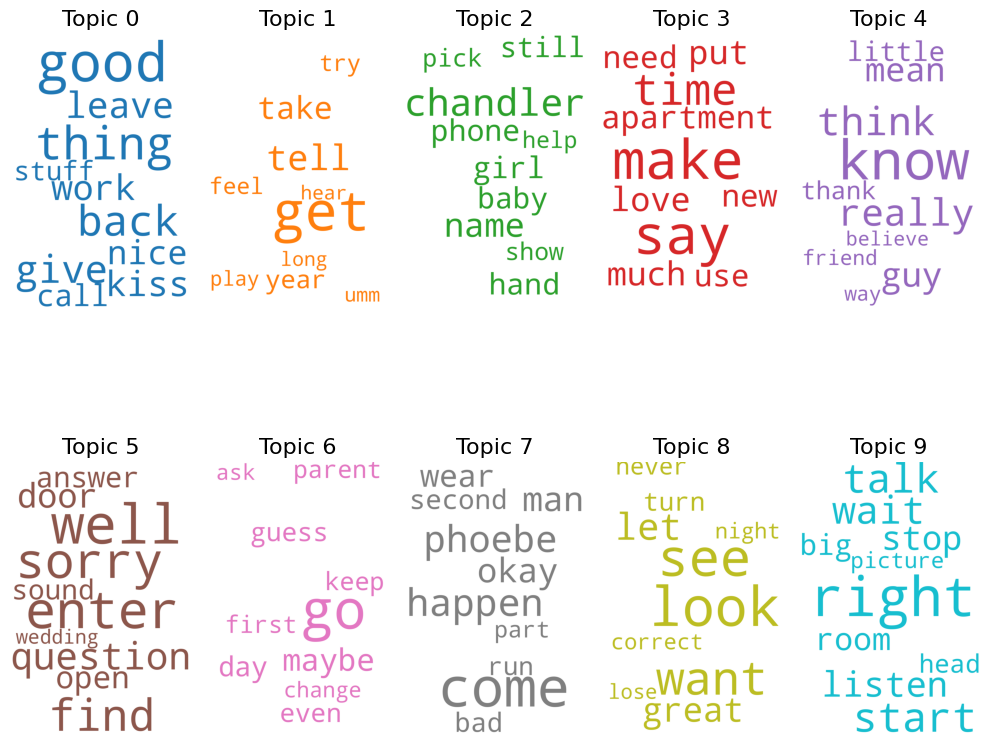

In [ ]:
# Word Clouds of Top N Keywords in Each Topic

from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=1000,
                  height=1500,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()